In [1]:
!pip install ultralytics opendatasets opencv-python

In [2]:
import opendatasets as od 
import pandas 
  
od.download("https://www.kaggle.com/datasets/kooaslansefat/uav-segmentation-aeroscapes/code") 


Skipping, found downloaded files in "./uav-segmentation-aeroscapes" (use force=True to force download)


In [3]:
import os
import sys
import time
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

# TensorFlow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

from IPython.display import YouTubeVideo
import albumentations as A

# Set environment settings and pandas display options
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'#nazmdehi warning va loghaye ezafi
pd.set_option('display.max_columns', None)#nmayesh hameye setoonha
pd.set_option('display.max_rows', None)#namayesh hameye satrha
pd.set_option('display.max_colwidth', None)#tanzim karektorha baraye arze setoonha

# Setting styles
sns.set_style('darkgrid')

# Warning settings
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from ultralytics import YOLO

import pathlib 

print('All modules have been imported')

2024-12-28 06:34:40.845070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735367680.861901    1041 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735367680.867164    1041 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 06:34:40.884733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is availa

All modules have been imported


In [4]:
IMAGE_PATH = 'uav-segmentation-aeroscapes/aeroscapes/JPEGImages/'
MASK_PATH = 'uav-segmentation-aeroscapes/aeroscapes/Visualizations/'

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

#split data
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Total Images:  3269
Train Size   :  2500
Val Size     :  442
Test Size    :  327


In [10]:
image_directory = 'uav-segmentation-aeroscapes/aeroscapes/JPEGImages/'
mask_directory = 'uav-segmentation-aeroscapes/aeroscapes/Visualizations/'

# Assuming that the images and masks have the same names
image_files = os.listdir(image_directory)
mask_files = os.listdir(mask_directory)

# Create a list to store the image file paths and corresponding labels
data = []

for image_file in tqdm(image_files):
    image_path = os.path.join(image_directory, image_file)
    mask_file = image_file.replace(".jpg", ".png")  # Assuming masks have .png extension
    mask_path = os.path.join(mask_directory, mask_file)

    # Load the mask as an RGB image
    mask = cv2.imread(mask_path)

    # Convert the mask to RGB format for comparison
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    # Check if the mask contains a person (RGB value [192, 128, 128])
    is_person = 1 if np.any(np.all(mask_rgb == [192, 128, 128], axis=-1)) else 0

    data.append((image_path, is_person))

  0%|          | 0/3269 [00:00<?, ?it/s]

In [11]:
df = pd.DataFrame(data, columns=["filepaths", "labels"])
df['labels'] =df['labels'].apply(lambda x: str(x))
df.head()

,filepaths,labels
0,uav-segmentation-aeroscapes/aeroscapes/JPEGImages/000001_001.jpg,1
1,uav-segmentation-aeroscapes/aeroscapes/JPEGImages/000001_002.jpg,1
2,uav-segmentation-aeroscapes/aeroscapes/JPEGImages/000001_003.jpg,1
3,uav-segmentation-aeroscapes/aeroscapes/JPEGImages/000001_004.jpg,1
4,uav-segmentation-aeroscapes/aeroscapes/JPEGImages/000001_005.jpg,1


In [12]:
df.labels.unique()

array(['1', '0'], dtype=object)

In [13]:
def split_df(df, trsize, column):
    train_df, dummy_df = train_test_split(df, train_size=trsize, shuffle=True, random_state=123, stratify=df[column])
    valid_df, test_df= train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df[column])
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    return train_df, test_df, valid_df    

train_df, test_df, valid_df  = split_df(df, .8, 'labels')

train_df length:  2615   test_df length:  327   valid_df length:  327


In [34]:
def plot_label_count (df, plot_title):
    column='labels'
    xaxis_label='CLASS'
    yaxis_label='IMAGE COUNT'
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()    
    values=vcounts.tolist() 
    lcount=len(labels)

        
    plt.figure() 
    plt.bar(labels, values)
    plt.title(plot_title)
    plt.xlabel(xaxis_label)
    plt.ylabel(yaxis_label)
    
    for i in range(lcount):
        plt.text(i, values[i]/2, str(values[i]))        
    plt.show()

labels
1    2077
0     538
Name: count, dtype: int64


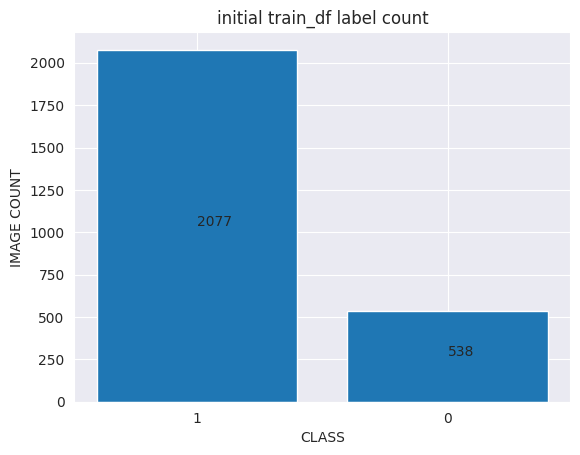

In [35]:
count=train_df['labels'].value_counts()
print (count)
plot_title='initial train_df label count'
plot_label_count (train_df, plot_title)